## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from graph_tool.all import *

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

## Optional: set number of threads

In [3]:
openmp_set_num_threads(6)
openmp_get_num_threads()

6

## Create graph from txt files

In [ ]:
nodes = {}
outliers = ["Forest\n", "Plains\n", "Island\n", "Mountain\n", "Swamp\n"]
current_deck = np.full(shape = 110, fill_value = -1)
g = Graph(directed = False)
eweight = g.new_ep("int32_t")
vcount  = g.new_vp("int32_t")
vname   = g.new_vp("string")

for i in range(100):
    file = str(i) + ".txt"
    print("Reading file " + file)
    graphfile = open(file)
    count = 0
    for line in graphfile:
        if line != "\n":
            if line in outliers:
                continue
            if line not in nodes:
                v = g.add_vertex()
                vcount[v] = 1
                vname[v]  = line.rstrip()
                nodes[line] = g.vertex_index[v]
            else:
                vcount[g.vertex(nodes[line])] = vcount[g.vertex(nodes[line])] + 1
            current_deck[count] = nodes[line]
            count = count + 1
        else:
            j = 0
            while current_deck[j] != -1:
                k = j + 1
                while current_deck[k] != -1:
                    e = g.edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
                    if (e == None):
                        e = g.add_edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
                        eweight[e] = 1
                    else:
                        eweight[e] = eweight[e] + 1
                    k = k + 1
                j = j + 1
            # Reset current deck and count
            current_deck = np.full(shape = 110, fill_value = -1)
            count = 0
    j = 0
    while current_deck[j] != -1:
        k = j + 1
        while current_deck[k] != -1:
            e = g.edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
            if (e == None):
                e = g.add_edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
                eweight[e] = 1
            else:
                eweight[e] = eweight[e] + 1
            k = k + 1
        j = j + 1
    # Reset current deck and count
    current_deck = np.full(shape = 110, fill_value = -1)
    #print(nodes)
    #print(current_deck)
    graphfile.close()

## Save properties inside the graph object

In [55]:
g.vp["vName"]   = vname
g.vp["vCount"]  = vcount
g.ep["eWeight"] = eweight.copy(value_type="double")

## Normalize data according to M

In [93]:
maxWeight = np.max(g.ep["eWeight"].a)
eWeightMNorm = g.ep["eWeight"].copy(value_type="double").t(lambda x: maxWeight + 1 - x)
g.ep["eWeightMNorm"] = eWeightMNorm

## Normalize weights by inversion

In [94]:
eWeightInvNorm = g.ep["eWeight"].copy(value_type="double").t(lambda x: 1.0 / x)
g.ep["eWeightInvNorm"] = eWeightInvNorm

## Normalize by bringing mean close to zero and standard deviation to 1

In [38]:
arrayWeights = g.ep["eWeight"].get_array()
mean         = np.mean(arrayWeights)
std          = np.std(arrayWeights)
eWeightZ     = g.ep["eWeight"].copy(value_type="double").t(lambda x: (x - mean) / std)
#g.ep["eWeightZ"] = eWeightZ

## 0-1 Normalization

In [12]:
def unitIntervalNormalization(edge_prop=g.ep["eWeight"]):
    min_val = min(edge_prop.a)
    max_val = max(edge_prop.a)
    if max_val > min_val:
        propMaxMin   = g.new_ep("double")
        propMaxMin.a = (edge_prop.a - min_val) / (max_val - min_val)
    else:
        propMaxMin   = edge_prop.copy(value_type="double")

    return propMaxMin
    
    #g.ep["eWeightMaxMin"] = eWeightMaxMin

## Saving and loading graph from file

In [20]:
g.save("graph.gt", fmt='gt')

In [4]:
g = Graph(directed = False)
g.load("graph.gt")

## Print the list of properties stored inside the graph

In [5]:
print(g.list_properties())

vBetweennessClassic       (vertex)  (type: double)
vBetweennessInvNorm       (vertex)  (type: double)
vBetweennessMNorm         (vertex)  (type: double)
vClosenessClassic         (vertex)  (type: double)
vClosenessInvNorm         (vertex)  (type: double)
vClosenessMNorm           (vertex)  (type: double)
vCount                    (vertex)  (type: int32_t)
vLocClusteringClassic     (vertex)  (type: double)
vLocClusteringInvNorm     (vertex)  (type: double)
vLocClusteringMNorm       (vertex)  (type: double)
vName                     (vertex)  (type: string)
vPagerankClassic          (vertex)  (type: double)
vPagerankInvNorm          (vertex)  (type: double)
vPagerankMNorm            (vertex)  (type: double)
eWeight                   (edge)    (type: int32_t)
eWeightInvNorm            (edge)    (type: double)
eWeightMNorm              (edge)    (type: double)
None


## Draw graph and print number of vertices and edges

In [ ]:
graph_draw(g, output="graph.png")

print("The number of nodes is " + str(g.num_vertices()))
print("The number of edges is " + str(g.num_edges()))

## Compute node positions

In [ ]:
#pos = sfdp_layout(g)
pos = sfdp_layout(g, eweight=g.ep["eWeight"])

In [ ]:
g.vp["pos"] = pos

In [ ]:
graph_draw(g, pos=g.vp["pos"], output="graph.png")

## Betweenness

In [58]:
vBetweennessClassic, eBetweennessClassic = betweenness(
    g, weight=g.ep["eWeight"])

In [ ]:
g.vp["vBetweennessClassic"] = vBetweennessClassic

In [9]:
vBetweennessMNorm, eBetweennessMNorm = betweenness(
    g, weight=g.ep["eWeightMNorm"])

In [10]:
g.vp["vBetweennessMNorm"] = vBetweennessMNorm

In [ ]:
vBetweennessInvNorm, eBetweennessInvNorm = betweenness(
    g, weight=g.ep["eWeightInvNorm"])

In [90]:
g.vp["vBetweennessInvNorm"] = vBetweennessInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(vb, 0, 1, power=.1),
#           vertex_size=prop_to_size(vb, 1, 12, power=.2), vorder=vb,
#           output="betweenness.png")

## PageRank metric

In [59]:
vPagerankClassic = pagerank(g, weight = g.ep["eWeight"])

In [ ]:
g.vp["vPagerankClassic"] = vPagerankClassic

In [14]:
vPagerankMNorm = pagerank(g, weight=g.ep["eWeightMNorm"])

In [15]:
g.vp["vPagerankMNorm"] = vPagerankMNorm

In [18]:
vPagerankInvNorm = pagerank(g, weight=g.ep["eWeightInvNorm"])

In [19]:
g.vp["vPagerankInvNorm"] = vPagerankInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(pr, 0, 1, power=.1),
#           vertex_size=prop_to_size(pr, 1, 12, power=.2), vorder=pr,
#           output="pagerank.png") # 7 minutes

## Closeness

In [60]:
vClosenessClassic = closeness(g, weight=g.ep["eWeight"]) # 12 minutes

In [ ]:
g.vp["vClosenessClassic"] = vClosenessClassic

In [7]:
vClosenessMNorm = closeness(g, weight=g.ep["eWeightMNorm"])

In [8]:
g.vp["vClosenessMNorm"] = vClosenessMNorm

In [87]:
vClosenessInvNorm = closeness(g, weight=g.ep["eWeightInvNorm"])

In [88]:
g.vp["vClosenessInvNorm"] = vClosenessInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(c, 0, 1, power=.1),
#           vertex_size=prop_to_size(c, 1, 12, power=.2), vorder=c,
#           output="closeness.png")

## Local clustering coefficients

In [13]:
vLocClusteringClassic = local_clustering(g, weight=unitIntervalNormalization(g.ep["eWeight"]))

In [14]:
g.vp["vLocClusteringClassic"] = vLocClusteringClassic

In [15]:
vLocClusteringMNorm = local_clustering(g, weight=unitIntervalNormalization(g.ep["eWeightMNorm"]))

In [16]:
g.vp["vLocClusteringMNorm"] = vLocClusteringMNorm

In [17]:
vLocClusteringInvNorm = local_clustering(g, weight=unitIntervalNormalization(g.ep["eWeightInvNorm"]))

In [18]:
g.vp["vLocClusteringInvNorm"] = vLocClusteringInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(vCl, 0, 1, power=.1),
#           vertex_size=prop_to_size(vCl, 1, 12, power=.2), vorder=vCl,
#           output="loc_clustering.png")

## Export betweenness and closeness to csv file

In [ ]:
betweenness = g.vp["vBetweennessClassic"].get_array()
closeness = g.vp["vClosenessClassic"].get_array()

In [ ]:
d = {'betweenness': betweenness, 'closeness': closeness}
df = pd.DataFrame(data=d)
MyMatrix = df.to_numpy()

In [ ]:
df.to_csv("out.csv")

## Print 20 of the cards with the highest score

In [33]:
closeness_array = g.vp["vLocClusteringClassic"].get_array()
kth = -20
ind = np.argpartition(closeness_array, kth)[kth:]
print([g.vp["vName"][index] for index in ind])

['Brightmare', 'Inspiring Unicorn', 'Daybreak Charger', 'Noble Quarry', 'Mesa Unicorn', 'Valorous Steed', 'Neighborhood Guardian', 'Ethereal Champion', 'Return to the Earth', 'Auriok Salvagers', 'Mountain Bandit', 'Lightfoot Rogue', 'Sphinx of the Chimes', 'Search the City', 'Crimson Kobolds', 'Crookshank Kobolds', 'Circu, Dimir Lobotomist', 'Manipulate Fate', 'Polluted Delta', 'Extract']


## Embedding and Clustering

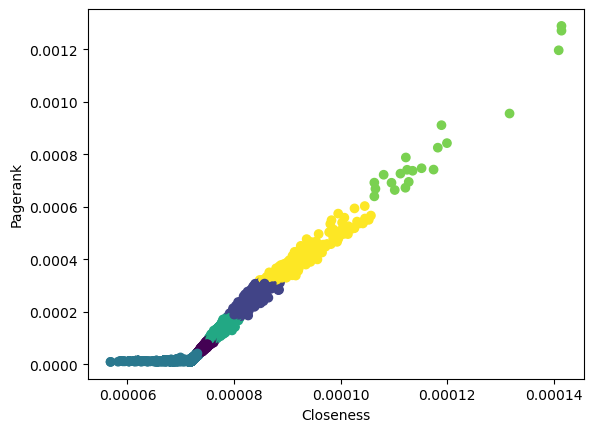

In [32]:
closeness_array = g.vp["vClosenessMNorm"].get_array()
pagerank_array = g.vp["vPagerankMNorm"].get_array()

embedding_points = np.transpose(np.vstack((closeness_array, pagerank_array)))

k = 6
pred = KMeans(n_clusters=k).fit_predict(embedding_points)

plt.scatter(embedding_points[:, 0], embedding_points[:, 1], c=pred)
plt.xlabel("Closeness")
plt.ylabel("Pagerank")
plt.show()

In [21]:
# get some random samples for each cluster
_, clust_indexes, clust_sizes = np.unique(pred, return_index=True, return_counts=True)
print(clust_sizes)

for i in range(0, k):
    print(f"=====>Cluster {i}, size {clust_sizes[i]}")

    cluster_node_indices = np.where(pred == i)[0]
    
    cards_in_cluster = [g.vp["vName"][random.choice(cluster_node_indices)] for _ in range(0, 20)]
    cards_in_cluster.sort()

    query = ""
    for name in cards_in_cluster:
        query += f"!\"{name}\" or "
    print(query.removesuffix(" or "))

[11602   652  1828   196  4348    21]
=====>Cluster 0, size 11602
!"Anathemancer" or !"Angel of Renewal" or !"At Knifepoint" or !"Bind the Monster" or !"Bubble Smuggler" or !"Gilded Light" or !"Goatnap" or !"Guildscorn Ward" or !"Lazav, Familiar Stranger" or !"Navigator's Compass" or !"Necroskitter" or !"Phantom Blade" or !"Scourge of the Nobilis" or !"Skitter Eel" or !"Tamiyo Meets the Story Circle" or !"Temporal Adept" or !"Thallid Omnivore" or !"Unholy Strength" or !"Vessel of Paramnesia" or !"Wick's Patrol"
=====>Cluster 1, size 652
!"Authority of the Consuls" or !"Bala Ged Recovery" or !"Boros Guildgate" or !"Fanatic of Rhonas" or !"Inspiring Call" or !"Leyline of Mutation" or !"Lotus Cobra" or !"Murmuring Bosk" or !"Noble Hierarch" or !"Reality Shift" or !"Rivendell" or !"Selesnya Signet" or !"Shadowy Backstreet" or !"Sheltering Landscape" or !"Skycloud Expanse" or !"Spore Frog" or !"Taiga" or !"Talisman of Creativity" or !"Talon Gates of Madara" or !"Tyrite Sanctum"
=====>Cluste

In [14]:
def basicCardInfo(g, v, index, pred):
    print(f"Name: {g.vp["vName"][v]}")
    print(f"Cluster: {pred[index]}")
    print(f"Coordinates: ({g.vp["vLocClusteringMNorm"][v]:.3e}, {g.vp["vClosenessMNorm"][v]:.3e}, {g.vp["vPagerankMNorm"][v]:.3e})")
    print(f"Appears {g.vp["vCount"][v]} times")

card_name = "Field of the Dead"
for v in g.vertices():
    if g.vp["vName"][v] == card_name:
        for index in range(0, len(g.get_vertices())):
            if g.get_vertices()[index] == v:
                basicCardInfo(g, v, index, pred)

Name: Field of the Dead
Cluster: 5
Coordinates: (2.552e-01, 8.462e-05, 2.716e-04)
Appears 424 times


In [29]:
def getVertexByCardNames(name_list):
    result = []
    for i, v in enumerate(g2.vertices()):
        if g2.vp["vName"][v] in name_list:
            result.append((i, v))
    return result

cluster_node_indices = np.where(pred == 5)[0]
max_closeness = np.max(g.vp["vClosenessMNorm"])
max_pagerank = np.max(g.vp["vPagerankMNorm"])
for index in cluster_node_indices:
    perc_closeness = 100 * g.vp["vClosenessMNorm"][index] / max_closeness
    perc_pagerank = 100 * g.vp["vPagerankMNorm"][index] / max_pagerank
    print(f"{g.vp["vName"][index]}, {g.vp["vClosenessMNorm"][index]:.3e}({perc_closeness:.2f}%), {g.vp["vPagerankMNorm"][index]:.3e}({perc_pagerank:.2f}%)")

Command Tower, 1.414e-04(100.00%), 1.271e-03(98.59%)
Myriad Landscape, 1.063e-04(75.18%), 6.925e-04(53.71%)
Reliquary Tower, 1.182e-04(83.59%), 8.256e-04(64.04%)
Sol Ring, 1.414e-04(100.00%), 1.289e-03(100.00%)
Exotic Orchard, 1.317e-04(93.11%), 9.556e-04(74.12%)
Swiftfoot Boots, 1.125e-04(79.52%), 7.414e-04(57.51%)
Terramorphic Expanse, 1.122e-04(79.35%), 7.883e-04(61.14%)
Arcane Signet, 1.409e-04(99.63%), 1.196e-03(92.80%)
Chromatic Lantern, 1.112e-04(78.64%), 7.268e-04(56.38%)
Farseek, 1.121e-04(79.30%), 6.730e-04(52.20%)
Path to Exile, 1.101e-04(77.88%), 6.644e-04(51.54%)
Evolving Wilds, 1.189e-04(84.08%), 9.113e-04(70.68%)
Path of Ancestry, 1.199e-04(84.81%), 8.429e-04(65.38%)
Swords to Plowshares, 1.174e-04(83.03%), 7.421e-04(57.57%)
Cultivate, 1.135e-04(80.25%), 7.376e-04(57.22%)
Fellwar Stone, 1.152e-04(81.44%), 7.473e-04(57.97%)
Lightning Greaves, 1.128e-04(79.74%), 6.953e-04(53.94%)
Rampant Growth, 1.063e-04(75.17%), 6.402e-04(49.66%)
Rogue's Passage, 1.065e-04(75.32%), 6.690

## Diameter

In [21]:
source = 13848
diam, (card1, card2) = pseudo_diameter(g, source=source, weights=g.ep["eWeightMNorm"])
print(diam, g.vp["vName"][card1], g.vp["vName"][card2])

20868.0 Skyclave Squid +2 Mace
